# DCGAN

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LeakyReLU, Layer, Conv2D, BatchNormalization, Flatten, Conv2DTranspose

## Generator

In [2]:
class Generator(Model):
    def __init__(self):
        super().__init__()
        self.dense = Dense(7*7*512, use_bias=False, input_shape=(100,))
        self.bn = BatchNormalization()
        self.lrelu = LeakyReLU()
        
        self.deconv1 = Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False)
        self.bn1 = BatchNormalization()
        self.lrelu1 = LeakyReLU()
        
        self.deconv2 = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.bn2 = BatchNormalization()
        self.lrelu2 = LeakyReLU()
        
        self.deconv3 = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same')

    def call(self, x, training=None, mask=None):
        h = self.lrelu(self.bn(self.dense(x), training))
        h = tf.reshape(h, (-1, 7, 7, 512))
        h = self.lrelu1(self.bn1(self.deconv1(h), training))
        h = self.lrelu2(self.bn2(self.deconv2(h), training))
        return self.deconv3(h)

## Discriminator

In [3]:
class Discriminator(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(64, (5, 5), strides=(2, 2), padding='same')
        self.bn1 = BatchNormalization()
        self.lrelu1 = LeakyReLU()
        
        self.conv2 = Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        self.bn2 = BatchNormalization()
        self.lrelu2 = LeakyReLU()
        
        self.flatten = Flatten()
        self.dense = Dense(1, activation='sigmoid')

    def call(self, x, training=None, mask=None):
        h = self.lrelu1(self.bn1(self.conv1(x), training))
        h = self.lrelu2(self.bn2(self.conv2(h), training))
        return self.dense(h)

## Datasets

In [4]:
dataset = tfds.load(name='fashion_mnist', split=tfds.Split.TRAIN)
dataset = dataset.map(lambda x: tf.cast(x['image'], tf.float32) / 255.0).batch(32)

## Model, Optimizers

In [5]:
generator = Generator()
discriminator = Discriminator()

# 같이 사용하면 않됨. 따로 만들어서 사용해야 됨
optim_d = tf.optimizers.Adam(1e-4)
optim_g = tf.optimizers.Adam(1e-4)

# 같이 사용하면 않됨. 따로 만들어서 사용해야 됨
d_mean = tf.metrics.Mean()
g_mean = tf.metrics.Mean()

## Losses

In [6]:
def discriminator_loss(d_real, d_fake):
    # 1이 되게 학습 (잘 검출되게)
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_real), d_real)
    # 0이 되게 학습
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(d_fake), d_fake)
    return real_loss + fake_loss

def generator_loss(d_fake):
    # 1이 되게 학습 (real 유사하도록 생성되게)    
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_fake), d_fake)

## Training Step

In [7]:
@tf.function
def train_step(image, optim_d, optim_g):
    with tf.GradientTape() as tape_d, tf.GradientTape() as tape_g: 
        z = tf.random.normal([32, 100])
        
        # g는 fake 이미지임
        g = generator(z, training=True)
        
        d_real = discriminator(image, training=True)
        d_fake = discriminator(g, training=True)
        
        d_loss = discriminator_loss(d_real, d_fake)
        g_loss = generator_loss(d_fake)
        
        gradients_d = tape_d.gradient(d_loss, discriminator.trainable_weights)
        gradients_g = tape_g.gradient(g_loss, generator.trainable_weights)
    
    optim_d.apply_gradients(zip(gradients_d, discriminator.trainable_weights))
    optim_g.apply_gradients(zip(gradients_g, generator.trainable_weights))
    return d_loss, g_loss

## Training Loop

epoch: 1, d_loss: 1.063983678817749, g_loss: 0.9104344844818115


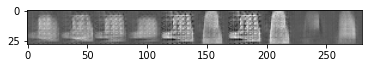

2064.820442199707 seconds elapsed.
epoch: 2, d_loss: 1.138993740081787, g_loss: 0.8757855892181396
2061.3511509895325 seconds elapsed.
epoch: 3, d_loss: 1.126791000366211, g_loss: 0.8981539011001587
2016.6248893737793 seconds elapsed.
epoch: 4, d_loss: 1.1437711715698242, g_loss: 0.8941957950592041
2090.578935623169 seconds elapsed.
epoch: 5, d_loss: 1.1338791847229004, g_loss: 0.9077661633491516
2033.5480539798737 seconds elapsed.
epoch: 6, d_loss: 1.1289790868759155, g_loss: 0.9178770184516907
2030.8492095470428 seconds elapsed.
epoch: 7, d_loss: 1.1366188526153564, g_loss: 0.9191427826881409
2091.8418262004852 seconds elapsed.
epoch: 8, d_loss: 1.1341866254806519, g_loss: 0.9269757866859436
2089.407496213913 seconds elapsed.
epoch: 9, d_loss: 1.1361582279205322, g_loss: 0.9305588006973267
2124.7222599983215 seconds elapsed.


KeyboardInterrupt: 

In [8]:
# 시간이 많이 소요됨. . 노트북의 경우 1 epoch당 34분 정도 소요됨
t = time.time()
sample_z = tf.random.normal([10, 100])
for epoch in range(100):
    for image in dataset:
        d_loss, g_loss = train_step(image, optim_d, optim_g)

        d_mean.update_state(d_loss)
        g_mean.update_state(g_loss)

    print('epoch: {}, d_loss: {}, g_loss: {}'.format(epoch+1, d_mean.result(), g_mean.result()))
    
    if epoch % 10 == 0:
        img_list = list()
        sample_img = generator(sample_z)
        for idx in range(sample_img.shape[0]):
            img_list.append(sample_img[idx][:, :, 0])
        img = np.concatenate(img_list, axis=1)
        plt.imshow(img, cmap='gray')
        plt.show()

    d_mean.reset_states()
    g_mean.reset_states()
    ct = time.time()
    print('{} seconds elapsed.'.format(ct - t))
    t = ct